# Image Classification

## Load the dataset

In [64]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

In [4]:
tf.random.set_seed(10)

In [5]:
assert len(tf.config.list_physical_devices('GPU')) == 1

In [2]:
data, data_test = tf.keras.datasets.fashion_mnist.load_data()

In [6]:
display(len(data))
display(type(data))
display(type(data_test))
display(len(data_test))

2

tuple

tuple

2

In [7]:
type(data[0])

numpy.ndarray

In [8]:
type(data[1])

numpy.ndarray

In [9]:
data[0].shape

(60000, 28, 28)

In [10]:
data[1].shape

(60000,)

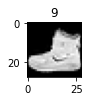

In [11]:
plt.figure(figsize=(1,1))
plt.imshow(data[0][0], cmap='gray')
plt.title(data[1][0])
plt.show()

In [18]:
label_categories = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

## Reading data

In [19]:
batch_size = 32

In [20]:
train_itter = tf.data.Dataset.from_tensor_slices(data).batch(batch_size).shuffle(len(data[0]))

## Defining Model

In [66]:
num_inputs = data[0].shape[1] * data[0].shape[2]
num_outputs = len(label_categories)

In [171]:
def init_model_params(no_of_features, no_of_output):
    w = tf.Variable(tf.random.normal((no_of_features, no_of_output), stddev=0.1), trainable=True)
    b = tf.Variable(tf.zeros((no_of_output)), trainable=True)
    return w, b

In [172]:
def test_init_model_params():
    w, b = init_model_params(100, 10)
    assert w.shape == (100, 10)
    assert b.shape == (10)
    assert not np.isnan(np.sum(w.numpy()))
    assert not np.isnan(np.sum(b.numpy()))
    print('Test sucessfull')


test_init_model_params()

Test sucessfull


In [215]:
def normalize_matrix(x):
    if type(x) != np.ndarray:
        x = x.numpy()
    return (x - x.mean()) / x.std()

In [217]:
def softmax_op(x):
    e_x = tf.exp(x)
    sum_e_x_k = tf.reduce_sum(e_x, 1, keepdims=True)
    return e_x / sum_e_x_k

In [218]:
def test_softmax_op():
    x = tf.random.normal((5, 2), 255, 0.01)
    x = normalize_matrix(x)
    softmax_x = softmax_op(x)
    assert softmax_x.dtype == tf.float32
    assert softmax_x.shape == x.shape
    sum_softmax_x = tf.reduce_sum(softmax_x, 1)
    assert [i == 1 for i in sum_softmax_x]
    print('Softmax test successfull')


test_softmax_op()

Softmax test successfull


In [188]:
def single_nn_model(x, w, b):
    x = tf.cast(tf.reshape(x, (-1, w.shape[0])), dtype=tf.float32)
    pred_raw = tf.matmul(x, w) + b
    return softmax_op(pred_raw)

In [236]:
def test_single_nn_model():
    no_of_feat = 100
    no_classes = 4
    no_of_examples = 1000
    w, b = init_model_params(no_of_feat, no_classes)
    x = tf.Variable(tf.random.normal((no_of_examples, no_of_feat)))
    pred = single_nn_model(x, w, b)
    assert pred.shape == (no_of_examples, no_classes)
    assert np.isfinite(np.sum(pred))
    print('Test Successfull')


test_single_nn_model()

Test Successfull


In [123]:
def cross_entropy_loss(y_pred, y_actual):
    one_hot_y = tf.one_hot(y_actual, depth=y_pred.shape[-1])
    assert one_hot_y.shape == y_pred.shape
    masked_y_pred = tf.boolean_mask(y_pred, one_hot_y)
    return - tf.math.log(masked_y_pred)

In [124]:
def test_cross_entropy():
    y_pred = tf.constant([[0.3, 0.5, 0.2], [0.1, 0.6, 0.3]])
    y_actual_good = tf.constant([1, 1])
    y_actual_bad = tf.constant([2, 0])
    loss_good = cross_entropy_loss(y_pred, y_actual_good)
    loss_bad = cross_entropy_loss(y_pred, y_actual_bad)
    assert (loss_good < loss_bad).numpy().all()
    print('Cross Entropy Test successful')


test_cross_entropy()

Cross Entropy Test successful


In [245]:
def accuracy(y_pred, y_actual):
    y_pred_class = tf.argmax(y_pred, axis=1)
    y_actual_class = tf.cast(y_actual, y_pred_class.dtype)
    comparison_matrix = (y_actual_class == y_pred_class)
    return tf.reduce_sum(tf.cast(comparison_matrix, y_pred.dtype))

In [246]:
def test_accuracy():
    y_pred = tf.constant([[0.3, 0.5, 0.2], [0.1, 0.6, 0.3]])
    y_actual_good = tf.constant([1, 1])
    y_actual_medium = tf.constant([1, 0])
    y_actual_bad = tf.constant([2, 0])
    acc_good = accuracy(y_pred, y_actual_good) / len(y_actual_good)
    acc_bad = accuracy(y_pred, y_actual_bad) / len(y_actual_bad)
    acc_medium = accuracy(y_pred, y_actual_medium) / len(y_actual_medium)
    assert acc_good == 1
    assert acc_bad == 0
    assert acc_medium == 0.5
    print('Accuracy Test Successfull')


test_accuracy()

Accuracy Test Successfull


In [247]:
def sgd_optimizer(params, gradients, learning_rate, batch_size):
    for param, grad in zip(params, gradients):
        param.assign(param - learning_rate * grad)

In [248]:
def test_sgd_optimizer():
    no_of_feat = 100
    no_classes = 4
    no_of_examples = 1000
    learning_rate = 0.01
    batch_size = 32
    w, b = init_model_params(no_of_feat, no_classes)
    x = tf.Variable(tf.random.normal((no_of_examples, no_of_feat)))
    y = tf.constant(tf.ones((no_of_examples), dtype=tf.int32))
    for i in range(0, 1000, 32):
        x_train = x[i:(i+32)]
        y_train = y[i:(i+32)]
        with tf.GradientTape() as g:
            pred = single_nn_model(x_train, w, b)
            loss = cross_entropy_loss(pred, y_train)
        params = [w, b]
        grad = g.gradient(loss, params)
        assert grad[0].shape == params[0].shape
        assert grad[1].shape == params[1].shape
        assert not np.isnan(np.sum(grad[0].numpy()))
        assert not np.isnan(np.sum(grad[1].numpy()))
        sgd_optimizer(params, grad, learning_rate, batch_size)
        assert not np.isnan(np.sum(params[0].numpy()))
        assert not np.isnan(np.sum(params[1].numpy()))
    print('Test Successfull')


test_sgd_optimizer()

Test Successfull


In [249]:
def gradient_descent(x, y, w, b):
    with tf.GradientTape() as g:
        y_pred = single_nn_model(x, w, b)
        assert np.isfinite(np.sum(y_pred.numpy())), print(y_pred)
        loss = cross_entropy_loss(y_pred, y)
        assert np.isfinite(np.sum(loss.numpy())), print(loss)
    trainable_params = [w, b]
    trainable_params_grad = g.gradient(loss, trainable_params)
    assert not np.isnan(np.sum(trainable_params_grad[0].numpy()))
    assert not np.isnan(np.sum(trainable_params_grad[1].numpy()))
    sgd_optimizer(trainable_params, trainable_params_grad, learning_rate, batch_size)

## Training

In [70]:
num_epochs = 1000
learning_rate = 0.01

In [65]:
history_accuracy = np.zeros((num_epochs))

In [241]:
w, b = init_model_params(num_inputs, num_outputs)

In [250]:
for epoch in range(num_epochs):
    for x, y in train_itter:
        x = normalize_matrix(x)
        gradient_descent(x, y, w, b)
    loss_epoch = cross_entropy_loss(single_nn_model(x, w, b), y)
    print('Loss in epoch {} is =====> {}'.format(epoch, loss_epoch.numpy().mean()))
    history_accuracy[epoch] = loss_epoch.numpy().mean()

tf.Tensor(
[ 5.7599249e+00 -0.0000000e+00  2.1300067e-01  3.7073421e+00
  8.4060486e+01  5.8514128e+00  6.0947609e+00  3.1090767e+01
  5.9922085e+00  1.7618975e+01  9.9175644e+00  2.1946275e+00
 -0.0000000e+00  1.1112756e-02  7.1090427e-03            inf
  5.6487747e+01  4.3366342e+00  6.5538473e+00  8.8811312e-06
 -0.0000000e+00  3.1463041e+01  1.1456907e+00  4.1507831e-01
  3.7935314e+00  8.6377800e+01  5.2956166e+00  4.3512337e-05
  1.8759341e-04  1.6122124e+01  1.2469424e+00  1.4813371e+01], shape=(32,), dtype=float32)


AssertionError: None